# Shared/hierarchical model demo using Neddermeyer data
Based on data from Higdon et al. 2008 'Computer Model Calibration Using High-Dimensional Output',
we compare shared, hierarchical, and independent calibrations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab

import os
import numpy as np
from scipy.interpolate import interp2d
from copy import deepcopy

from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData as SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaSharedThetaModels import SepiaSharedThetaModels
from sepia.SepiaHierarchicalThetaModels import SepiaHierarchicalThetaModels

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from nedderimp import nedderimp

def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return d

def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return out

### simulation design

In [2]:

design = np.array([
    [0.7714,    0.4286,    0.0286],
    [0.3714,    0.1143,    0.7143],
    [0.1714,    0.4571,    0.8857],
    [0.3429,    0.6000,    0.8000],
    [0.8000,    0.6286,    0.4000],
    [0.7429,    0.5429,         0],
    [0.6571,    1.0000,    0.6286],
    [0.2857,         0,    0.4571],
    [0.5143,    0.9429,    0.2286],
    [0.6857,    0.3143,    0.6571],
    [0.8286,    0.2000,    1.0000],
    [0.9714,    0.3429,    0.6000],
    [0.4000,    0.8000,    0.2000],
    [0.5429,    0.2857,    0.2857],
    [0.9143,    0.8857,    0.2571],
    [0.0571,    0.0286,    0.0857],
    [0.1143,    0.5714,    0.7429],
    [0.2000,    0.2286,    0.3714],
    [0.4571,    0.9143,    0.3429],
    [0.6286,    0.7143,    0.6857],
    [     0,    0.8286,    0.9429],
    [0.8857,    0.0857,    0.9714],
    [0.2286,    0.0571,    0.5714],
    [0.7143,    0.1714,    0.8571],
    [0.2571,    0.4857,    0.1429],
    [0.5714,    0.4000,    0.8286],
    [0.9429,    0.6857,    0.4857],
    [0.4857,    0.1429,    0.1143],
    [1.0000,    0.8571,    0.9143],
    [0.6000,    0.6571,    0.5143],
    [0.1429,    0.7429,    0.5429],
    [0.8571,    0.2571,    0.0571],
    [0.3143,    0.3714,    0.4286],
    [0.4286,    0.7714,    0.7714],
    [0.0286,    0.9714,    0.3143],
    [0.0857,    0.5143,    0.1714]])

# number of experiements and simulations
n = 3; m = design.shape[0]

# these parameter values simulate expt 10 in Neddermeyer '43
# params =             [R1      lam     s         rho   mratio   u0]
params10 = np.array([1.5*2.54, 2/3,  3e5*6.84e4,  7.5,   .32,   1.65e10])
paramslhs = np.zeros((m, 6))
for i in range(m):#
    paramslhs[i,:] = params10*np.array([1, 1, design[i,1]*.2+.9, 1, design[i,0]*.65+.5, design[i,2]*.2+.9])
# the simulation runs will vary mratio from .32*[.5 to 1.15]
#                                s      from s0*[.9 to 1.1]
#                                u0     from u0*[.9 to 1.1]


# Generate simulation data

In [3]:
nt = 22; nphi = 26
time = np.c_[np.linspace(0,5.0e-5,nt,endpoint=True)]
phi = np.linspace(0,1,nphi,endpoint=True) * 2*np.pi;
rinner = nedderimp(time,params10);
lam = params10[1]; R1 = params10[0];
router = np.sqrt(rinner**2 + 1 - lam**2);
xycirc = np.array([np.cos(phi),np.sin(phi)]).T
r = nedderimp(time,params10);
yr = np.zeros((m,nt))
for i in range(m):
    params = paramslhs[i,:]
    yr[i,:] = params[0]*nedderimp(time,params)
y_sim = np.tile(yr,nphi)
example_runs = [0,1,28]
# indices
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(time,26)
y_sim_ind_time_phi[:,1] = np.tile(phi,22)
x_sim = design[:,0].reshape(m,1)
t_sim = design[:,1:3]

# Generate observed data

In [4]:
phi_obs = np.arange(0,(2*np.pi-.1),(2*np.pi/16))
n_phi_obs = phi_obs.shape[0]
time_obs = [np.array([1.5e-5, 2.7e-5, 4.5e-5]),np.array([4.5e-5]),np.array([2.5e-5, 4.5e-5])]
n_time_obs = [tmp.shape[0] for tmp in time_obs]

phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
pphiknots = len(phiknots)
Ddelt = np.zeros((phi_obs.shape[0], pphiknots));
datadelt = np.matmul(Ddelt,dknots)

# observations
r_obs = [None]*3; y_obs = [None]*3
for i in range(3):
    obs_params = deepcopy(params10)
    if i==1: obs_params[4]=.17
    elif i==2: obs_params[4]=.36
    r_obs[i] = np.atleast_2d(obs_params[0]*nedderimp(time_obs[i],obs_params))
    y_obs[i] = np.tile(r_obs[i].T,phi_obs.shape[0]).reshape(n_phi_obs,n_time_obs[i]) 
    y_obs[i] += np.tile(datadelt,n_time_obs[i])
    y_obs[i] = (y_obs[i] + .01*np.random.normal(size=y_obs[i].shape)).flatten()

# indices of observations
x_obs = ((np.array([params10[4], .17, .36])/.32-.5)/.65).reshape(3,1)
# create y_ind_obs where each row is a (time, angle) pair. Pairs are grouped by time.
# experiment 1
y_ind_obs_1 = np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[0][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[0][1],\
                                       np.ones(phi_obs.shape[0])*time_obs[0][2])), np.tile(phi_obs,3).T ) )
# experiment 2
y_ind_obs_2 = np.column_stack( ( (np.ones(phi_obs.shape[0])*time_obs[1]).reshape(16,1), phi_obs.T ) )
# experiment 3
y_ind_obs_3 = np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[2][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[2][1])), np.tile(phi_obs,2).T ) )
# Store in a list containing all 3 experiments
y_ind_obs = [y_ind_obs_1, y_ind_obs_2, y_ind_obs_3]
del y_ind_obs_1, y_ind_obs_2, y_ind_obs_3

### Sepia Data

In [5]:
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_sim = y_sim, y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs, y_ind_obs = y_ind_obs)
data.transform_xt()

(None, None)

### K basis

In [6]:
# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
phimat = np.repeat(phi,nt).reshape((nt,nphi),order='F')
timemat = np.repeat(time,nphi).reshape((nt,nphi))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((nt,nphi),order='F'))
data.obs_data.orig_y_mean = []
data.obs_data.orig_y_sd = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    data.obs_data.orig_y_sd.append(data.sim_data.orig_y_sd)

# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

# for now, hack this in - if it used the inbuilt methods it would happen automatically
tSigy_std=[]
for i in range(len(data.obs_data.y)):
    tSigy_std.append(np.atleast_2d(np.diag(np.ones(data.obs_data.y[i].shape))))
data.obs_data.Sigy_std = tSigy_std
del tSigy_std

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(nt,nphi),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

### D basis

In [7]:
# compute the basis functions for the discrepancy function.
Dobs = []
Dsim  = np.zeros((phi.shape[0], pphiknots))
for k in range(pphiknots):
    Ddelt[:,k] = dnorm(dist2pi(phi_obs,phiknots[k]*np.ones(phi_obs.shape[0])),0,np.pi/8).T;
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[0])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)

simdelt = np.matmul(Dsim,dknots)
timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs.append(np.zeros((pv,data.obs_data.y_std[k].shape[0])))
    if k == 0: Dsim = np.zeros((pv,data.sim_data.y_std.shape[1]))
    for j in range(pv):
        Dobs[-1][j,:] = dnorm(y_ind_obs[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(y_ind_obs[k][:,1],knotlocsphi[j]*np.ones(y_ind_obs[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[j,:] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)

data.create_D_basis(D_obs=Dobs,D_sim=Dsim)

In [13]:
# Set up models
model = SepiaModel(data)
shared_model = SepiaSharedThetaModels([deepcopy(model), deepcopy(model)], np.array([[0, 0], [1, 1]]))
hier_model = SepiaHierarchicalThetaModels([deepcopy(model), deepcopy(model)], np.array([[0, 0], [1, 1]]))

In [17]:
model.do_mcmc(100)

MCMC sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.98it/s]


In [18]:
shared_model.do_mcmc(100)

MCMC sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.87it/s]


In [14]:
hier_model.do_mcmc(100)

MCMC sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.11it/s]


In [15]:
tmin = data.sim_data.orig_t_min
tmax = data.sim_data.orig_t_max
theta_true = {}
theta_true['theta0'] = 0.5217 * (tmax[0, 0] - tmin[0, 0]) + tmin[0, 0]
theta_true['theta1'] = 0.4874 * (tmax[0, 1] - tmin[0, 1]) + tmin[0, 1]

First we will compare the single model to the shared model (which uses the same data in both models, so it's like
using double the amount of data in the single model).
In the shared model, both of the thetas are shared between models so the samples will be identical in both models.
The call `shared_model.get_samples()` retrieves the samples for both models but we will only look at one of them.

In [19]:
# Extract samples
single_model_samples = model.get_samples()
shared_model_samples = shared_model.get_samples()

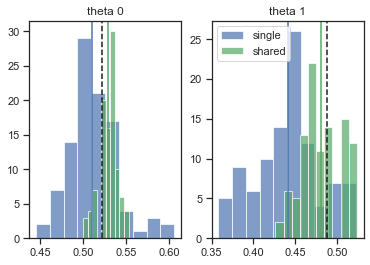

In [20]:
plt.figure()
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.hist(single_model_samples['theta_native'][:, i], alpha=0.7, color='b', label='single')
    plt.axvline(np.mean(single_model_samples['theta_native'][:, i]), color='b')
    plt.hist(shared_model_samples['model0']['theta_native'][:, i], alpha=0.7, color='g', label='shared')
    plt.axvline(np.mean(shared_model_samples['model0']['theta_native'][:, i]), color='g')
    plt.axvline(theta_true['theta%d'%i], color='k', linestyle='dashed')
    plt.title('theta %d' % i)
    if i == 1:
        plt.legend()

It appears that the single and shared models obtain nearly the same posterior mean for both thetas,
but the shared model posterior is more concentrated than the single model posterior.
This is what we expect: in this case, the shared model is essentially the same as the single model
with twice the amount of data.

What about the hierarchical model? The two models have similar posteriors that are again more concentrated than the single.

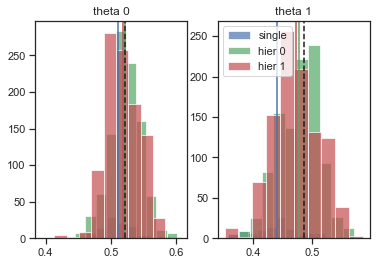

In [21]:
hier_model_samples = hier_model.get_samples()

plt.figure()
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.hist(single_model_samples['theta_native'][:, i], alpha=0.7, color='b', label='single')
    plt.axvline(np.mean(single_model_samples['theta_native'][:, i]), color='b')
    plt.hist(hier_model_samples['model0']['theta_native'][:, i], alpha=0.7, color='g', label='hier 0')
    plt.axvline(np.mean(hier_model_samples['model0']['theta_native'][:, i]), color='g')
    plt.hist(hier_model_samples['model1']['theta_native'][:, i], alpha=0.7, color='r', label='hier 1')
    plt.axvline(np.mean(hier_model_samples['model1']['theta_native'][:, i]), color='r')
    plt.axvline(theta_true['theta%d'%i], color='k', linestyle='dashed')
    plt.title('theta %d' % i)
    if i == 1:
        plt.legend()

The hierarchical means are near the true values of theta,
and the hierarchical variances are small, indicating the model has learned that the values of theta should
be similar between the two models.

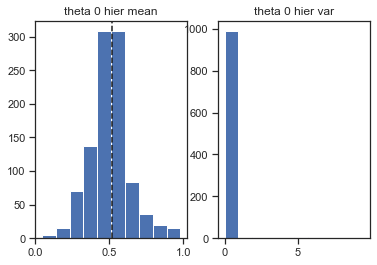

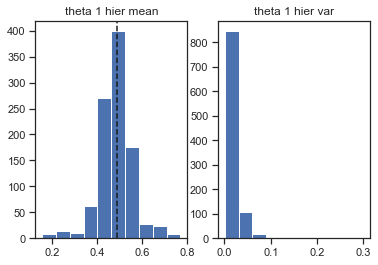

In [22]:
for i in range(2):
    plt.figure()
    plt.subplot(121)
    plt.hist(hier_model_samples['hier_mu%d'%i])
    plt.title('theta %d hier mean' % i)
    plt.axvline(theta_true['theta%d'%i], color='k', linestyle='dashed')
    plt.subplot(122)
    plt.hist(1./hier_model_samples['hier_lambda%d'%i])
    plt.title('theta %d hier var' % i)


## Prediction
Predictions can be made from shared models by using one of the models in the model list.

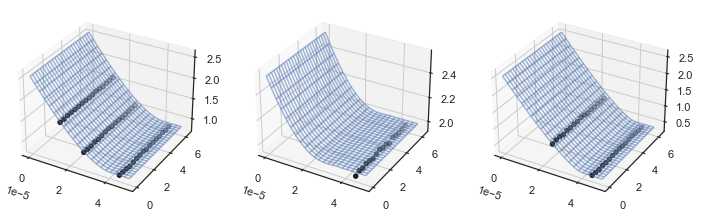

In [23]:
from sepia.SepiaPredict import SepiaEmulatorPrediction

pred = SepiaEmulatorPrediction(x_pred=x_obs, samples=shared_model_samples['model0'], model=shared_model.model_list[0])

pred_time, pred_phi = np.meshgrid(time, phi)
predy = pred.get_y()

fig = plt.figure(figsize=[12,6])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(xs = y_ind_obs[i][:,0], ys = y_ind_obs[i][:,1], zs = y_obs[i],color='k')
    ax.plot_wireframe(pred_time,pred_phi,np.mean(predy,0)[i,:].reshape(26,22),
                      alpha=.5)